In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, curve_fit
import astropy.units as u
import astropy.constants as const
import math
import statistics
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.signal as signal
import matplotlib.patches as mpatches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import (ListedColormap, LinearSegmentedColormap)

In [2]:
curve_fit?

Signature:
curve_fit(
    f,
    xdata,
    ydata,
    p0=None,
    sigma=None,
    absolute_sigma=False,
    check_finite=True,
    bounds=(-inf, inf),
    method=None,
    jac=None,
    **kwargs,
)
Docstring:
Use non-linear least squares to fit a function, f, to data.

Assumes ``ydata = f(xdata, *params) + eps``.

Parameters
----------
f : callable
    The model function, f(x, ...). It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : array_like or object
    The independent variable where the data is measured.
    Should usually be an M-length sequence or an (k,M)-shaped array for
    functions with k predictors, but can actually be any object.
ydata : array_like
    The dependent data, a length M array - nominally ``f(xdata, ...)``.
p0 : array_like, optional
    Initial guess for the parameters (length N). If None, then the
    initial values will all be 1 (if the number of parameters for the
    func

In [3]:
# Errores a considerar

err_amp = 10  # microamp
err_volt = 0.0005 # volt

In [8]:
# Filtros

filtros_nm = [405, 436, 546, 580]

In [13]:
# Armamos un DataFrame con todos los datos obtenidos

volt_frenado_1 = [1.366, 1.015, 0.604, 0.537]
volt_frenado_2 = [1.293, 0.996, 0.665, 0.520]
volt_frenado_3 = [1.430, 1.115, 0.715, 0.545]
corriente_inicial = [385, 140, 210, 90]

datos_dict = {
    'Filtros (nm)': filtros_nm,
    'Volt_Frenado_1 (V)': volt_frenado_1,
    'Volt_Frenado_2 (V)': volt_frenado_2,
    'Volt_Frenado_3 (V)': volt_frenado_3,
    'Corriente_Inicial (μA)': corriente_inicial_1,
    'Err_V': [err_volt for i in range(len(filtros_nm))],
    'Err_amp': [err_amp for i in range(len(filtros_nm))]
}

datos_fotoelect = pd.DataFrame(datos_dict)
datos_fotoelect


,Filtros (nm),Volt_Frenado_1 (V),Volt_Frenado_2 (V),Volt_Frenado_3 (V),Corriente_Inicial (μA),Err_V,Err_amp
0,405,1.366,1.293,1.430,385,0.0005,10
1,436,1.015,0.996,1.115,140,0.0005,10
2,546,0.604,0.665,0.715,210,0.0005,10
3,580,0.537,0.520,0.545,90,0.0005,10


In [23]:
# Definimos esta función para encontrar el promedio de los voltajes de frenado, con sus respectivas
# desviaciones estándar

def mean_std_volt(volt_frenado_1, volt_frenado_2, volt_frenado_3):
    list_mean = list()
    list_std = list()
    for i in range(len(volt_frenado_1)):
        list_mean.append(np.mean(
            [volt_frenado_1[i], volt_frenado_2[i], volt_frenado_3[i]]
        ))
        list_std.append(np.std(
            [volt_frenado_1[i], volt_frenado_2[i], volt_frenado_3[i]]
        ))
    return list_mean, list_std

In [24]:
mean_volt, std_volt = mean_std_volt(datos_fotoelect['Volt_Frenado_1 (V)'],
                                    datos_fotoelect['Volt_Frenado_2 (V)'],
                                    datos_fotoelect['Volt_Frenado_3 (V)'])
mean_volt, std_volt

([1.3629999999999998, 1.042, 0.6613333333333333, 0.5339999999999999],
 [0.055970230182362725,
  0.052198339692624975,
  0.04538967087589667,
  0.010424330514074601])

In [26]:
datos_fotoelect['Volt_Frenado_Mean (V)'] = mean_volt
datos_fotoelect['Volt_Frenado_STDDEV (V)'] = std_volt
datos_fotoelect

,Filtros (nm),Volt_Frenado_1 (V),Volt_Frenado_2 (V),Volt_Frenado_3 (V),Corriente_Inicial (μA),Err_V,Err_amp,Volt_Frenado_Mean (V),Volt_Frenado_STDDEV (V)
0,405,1.366,1.293,1.430,385,0.0005,10,1.363000,0.055970
1,436,1.015,0.996,1.115,140,0.0005,10,1.042000,0.052198
2,546,0.604,0.665,0.715,210,0.0005,10,0.661333,0.045390
3,580,0.537,0.520,0.545,90,0.0005,10,0.534000,0.010424


In [31]:
# Combinación de errores: como la desviación estándar y el error instrumental no tienen correlación,
# podemos usar el método RSS (root-sum-square), es decir, tomar la raíz cuadrada de la suma de los cuadrados de desviación
# estándar y de error instrumental, para así obtener el error combinado total de los voltajes de frenado

volt_err_comb = np.sqrt((datos_fotoelect['Volt_Frenado_STDDEV (V)'] ** 2) + (datos_fotoelect['Err_V'] ** 2))
datos_fotoelect['Volt_Comb_Err (V)'] = volt_err_comb
datos_fotoelect

,Filtros (nm),Volt_Frenado_1 (V),Volt_Frenado_2 (V),Volt_Frenado_3 (V),Corriente_Inicial (μA),Err_V,Err_amp,Volt_Frenado_Mean (V),Volt_Frenado_STDDEV (V),Volt_Comb_Err (V)
0,405,1.366,1.293,1.430,385,0.0005,10,1.363000,0.055970,0.055972
1,436,1.015,0.996,1.115,140,0.0005,10,1.042000,0.052198,0.052201
2,546,0.604,0.665,0.715,210,0.0005,10,0.661333,0.045390,0.045392
3,580,0.537,0.520,0.545,90,0.0005,10,0.534000,0.010424,0.010436


## Análisis

### 1.- Gráfico voltaje de frenado v/s 1/lambda

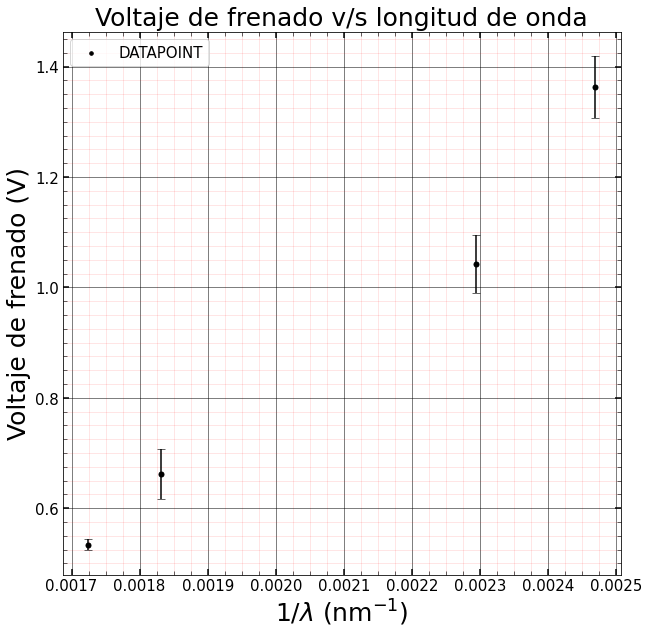

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.errorbar(1/datos_fotoelect['Filtros (nm)'], datos_fotoelect['Volt_Frenado_Mean (V)'], yerr = datos_fotoelect['Volt_Comb_Err (V)'],
              fmt = '.', markersize = '10', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6 )
ax1.scatter(1/datos_fotoelect['Filtros (nm)'], datos_fotoelect['Volt_Frenado_Mean (V)'], marker=".", s=50, c="black", label='DATAPOINT')
ax1.set_title('Voltaje de frenado v/s longitud de onda', fontsize=25)
ax1.set_ylabel(r'Voltaje de frenado (V)', fontsize=25)
ax1.set_xlabel(r'1/$\lambda$ (nm$^{-1}$)', fontsize=25)
ax1.yaxis.get_offset_text().set_fontsize(15)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

ax1.xaxis.set_minor_locator(MultipleLocator(0.000025))
ax1.yaxis.set_minor_locator(MultipleLocator(0.025))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)

### 2.- Por un método gráfico y utilizando la ecuación (4), obtenga un valor para la constante de Planck (recuerde que hay que contar el error o incertidumbres en la medición).

$$h\nu = w_{0} +eV \tag{4}$$

$$\rightarrow \hspace{3mm} eV = h\nu - w_{0}$$

In [45]:
# Definimos una función de la forma y = mx + b, donde la pendiente m = h, x = \nu, y el intercepto b = -w0

def modelo_fotoelectrico(frecuencia, const_planck, funcion_trabajo):
    return (frecuencia * const_planck) - funcion_trabajo

In [91]:
# Definimos los datos que necesitamos, con las unidades pertinentes

electron_volts = ((np.array(datos_fotoelect['Volt_Frenado_Mean (V)']) * u.V * const.e.si).to(u.eV)).to(u.J).value # eV (Joules)
err_electron_volts = ((np.array(datos_fotoelect['Volt_Comb_Err (V)']) * u.V * const.e.si).to(u.eV)).to(u.J).value # eV (Joules)
frecuencias = (const.c / (np.array(datos_fotoelect['Filtros (nm)']) * u.nm).to(u.m)).value # nu (1/s)


In [96]:
# A través de curve_fit, encontramos los mejores valores para la pendiente y el intercepto

popt, pcov = curve_fit(modelo_fotoelectrico, frecuencias, electron_volts, sigma=err_electron_volts)

# En la documentación de curve_fit, aparece que el error de los parametros estimados se obtiene de esta manera
perr = np.sqrt(np.diag(pcov))
perr

array([4.30831628e-35, 2.29889060e-20])

In [159]:
popt[1]

1.981378858398716e-19

In [153]:
err_porcentual_h = (perr[0] * 100) / popt[0]
err_porcentual_w_0 = (perr[1] * 100) / popt[1]
dif_porcentual_teo_exp_h = (100 * np.abs(popt[0] - const.h.value)) / const.h.value
err_dif_porcentual_teo_exp_h = np.abs(dif_porcentual_teo_exp_h - (100 * np.abs(popt[0] + perr[0] - const.h.value)) / const.h.value)


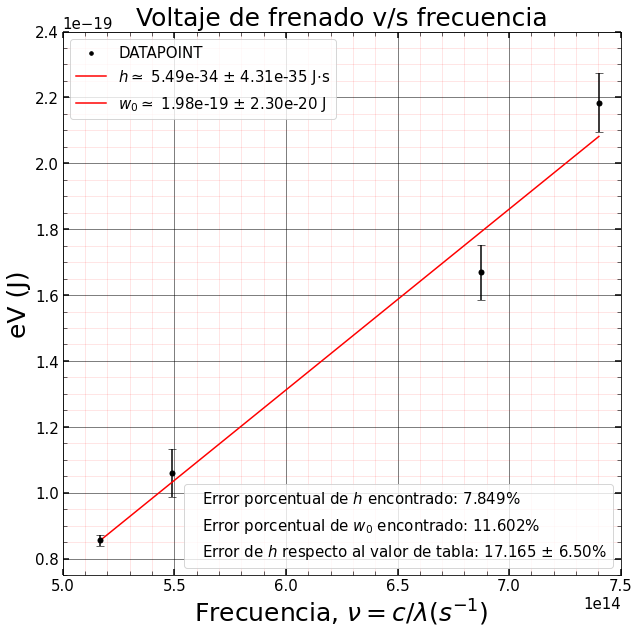

In [166]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.errorbar(frecuencias, electron_volts, yerr = err_electron_volts,
              fmt = '.', markersize = '10', ecolor = 'Black', color = 'Black',capsize=4, capthick=0.6)
ax1.scatter(frecuencias, electron_volts, marker=".", s=50, c="black", label='DATAPOINT')
ax1.plot(frecuencias, modelo_fotoelectrico(frecuencias, popt[0], popt[1]),c='red',label=r'$h \simeq$ {:.2e} ± {:.2e} J$\cdot$s'.format(popt[0], perr[0]))

# ax1.axhline(modelo_fotoelectrico(0,0,popt[1])) --> linea horizontal que muestra el intercepto con el eje y, es decir, el valor de la funcion trabajo

ax1.axvline(1, c='red',label=r'$w_0 \simeq$ {:.2e} ± {:.2e} J'.format(popt[1], perr[1]))
ax1.set_title('Voltaje de frenado v/s frecuencia', fontsize=25)
ax1.set_ylabel(r'eV (J)', fontsize=25)
ax1.set_xlabel(r'Frecuencia, $\nu = c/\lambda (s^{-1})$', fontsize=25)
ax1.yaxis.get_offset_text().set_fontsize(15)
ax1.xaxis.get_offset_text().set_fontsize(15)
ax1.set_xlim(500000000000000, 750000000000000)
ax1.set_ylim(.000000000000000000075, .00000000000000000024)

ax1.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
              length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
              grid_linewidth=0.5)

extra_legend_1 = mpatches.Patch(label=r'Error porcentual de $h$ encontrado: {:.3f}%'.format(err_porcentual_h))
extra_legend_2 = mpatches.Patch(label=r'Error porcentual de $w_0$ encontrado: {:.3f}%'.format(err_porcentual_w_0))
extra_legend_3 = mpatches.Patch(label=r'Error de $h$ respecto al valor de tabla: {:.3f} ± {:.2f}%'.format(dif_porcentual_teo_exp_h, err_dif_porcentual_teo_exp_h))

handles, labels = ax1.get_legend_handles_labels()
handles.append(extra_legend_1)
handles.append(extra_legend_2)
handles.append(extra_legend_3)
extra_legend = ax1.legend(handles=[extra_legend_1, extra_legend_2, extra_legend_3], loc='lower right', bbox_to_anchor=(1.0, 0.0), fontsize=15, markerscale=0, handlelength=0)
extra_legend.legendHandles[0].set_visible(False)
extra_legend.legendHandles[1].set_visible(False)
extra_legend.legendHandles[2].set_visible(False)
ax1.add_artist(extra_legend)

ax1.xaxis.set_minor_locator(MultipleLocator(10000000000000))
ax1.yaxis.set_minor_locator(MultipleLocator(0.000000000000000000005))
ax1.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')

ax1.grid(True, which='both')
ax1.legend(fontsize=15)